# Computational Social Science Project #2 

**Enter your Name:**_ Sumate Pruekruedee_

*Semester:* Fall 2023


Below we fill in some of the code you might use to answer some of the questions. Here are some additional resources for when you get stuck:
* Code and documentation provided in the course notebooks  
* [Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to help with formatting the Jupyter notebook
* Try Googling any errors you get and consult Stack Overflow, etc. Someone has probably had your question before!
* Send me a pull request on GitHub flagging the syntax that's tripping you up 

**INSTRUCTIONS:** For this project, copy all of the files in the Project 2 folder in the course repo into a "Project 2" subfolder within the "Computational Social Science Projects" directory that you created for the first project. You will work on the project locally, push your project to GitHub, and submit a link to the GitHub repo on bCourses by the project deadline. Be sure the final submission is in the main branch, which is what I'll pull down and re-run to grade. 

## 1. Introduction/Setup

#### a) Import relevant libraries
Here are some libraries you will need to get started. Along the way you may need to add more. Best practice is to add them here at the top of the script.

In [216]:
#
# import libraries you might need here 
#-----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# use random seed for consistent results 
np.random.seed(273)

#### b) Read in and inspect data frame 
Read in the data frame and look at some of its attributes. Read in the data contained in the projoect folder: "Diabetes with Population Info by County 2017.csv".

In [217]:
#
# read in and inspect data frame
#-----------
# Note that "CountyFips" needs to be a string so the leading 0 isn't dropped (only if you want to make choropleth map) 
diabetes = pd.read_csv('Diabetes with Population Info by County 2017.csv', 
                       dtype={"CountyFIPS": str}) 

In [218]:
#
# look at shape
#-----------
# look at the dimensions of the diabetes data frame
print('shape: ', diabetes.shape) 
diabetes.columns

shape:  (3220, 95)


Index(['County', 'State', 'CountyFIPS', 'Diabetes_Number', 'Obesity_Number',
       'Physical_Inactivity_Number',
       'sex and age_total population_65 years and over_sex ratio (males per 100 females)',
       'race_total population', 'race_total population_one race',
       'race_total population_two or more races',
       'race_total population_one race_1',
       'race_total population_one race_white',
       'race_total population_one race_black or african american',
       'race_total population_one race_american indian and alaska native',
       'race_total population_one race_american indian and alaska native_cherokee tribal grouping',
       'race_total population_one race_american indian and alaska native_chippewa tribal grouping',
       'race_total population_one race_american indian and alaska native_navajo tribal grouping',
       'race_total population_one race_american indian and alaska native_sioux tribal grouping',
       'race_total population_one race_asian',
     

In [219]:
#
# set pandas parameters
#-----------
# tells pandas how many rows to display when printing so results don't get truncated
pd.set_option('display.max_rows', 100)

# look at the data types for each column in diabetes df (likely be located under each row bc column names are long)
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                          object
Obesity_Number                                                                                                                                           object
Physical_Inactivity_Number                                                                                                                               object
sex and age_total population

Immediately, we see that some of the features that should be numeric (e.g., Diabetes_Number, Obesity_Number,  and Physical_Inactivity_Number) are not. We can check to see what the non-numeric values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`.

In [220]:
#
# identify non-numeric features
#-----------
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows
# the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes["Diabetes_Number"].str.isnumeric()]["Diabetes_Number"].unique()) 

['Suppressed']


In [221]:
#
# Now do the same as above, but for "Obesity_Number"
#-----------
print(diabetes[~diabetes["Obesity_Number"].str.isnumeric()]["Obesity_Number"].unique()) 


['No Data']


In [222]:
#
# Now do the same as above, but for "Physical_Inactivity_Number" 
#-----------
print(diabetes[~diabetes["Physical_Inactivity_Number"].str.isnumeric()]["Physical_Inactivity_Number"].unique()) 

['No Data']


These values ("Suppresssed" and "No Data") contained in the two respective columns are coercing these features to objects instead of them being  integers. Let's drop those rows in the next section, and also recode "Physical_Inactivity_Number" feature to be an integer.

#### c. Recode variables

Convert 'Diabetes_Number', 'Obesity_Number', and 'Physical_Inactivity_Number' to integers below so we can use them in our analysis. Also fill in the object type we want to recode 'sex and age_total population_65 years and over_sex ratio (males per 100 females)' too (you'll have to scroll all the way over to the right).

In [223]:
#
# Recode variables
#-----------

# Diabetes
# ----------
# keep only useful info about our target feature, i.e., where diabetes_number not = 'Suppressed'
# note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 
diabetes = diabetes[diabetes['Diabetes_Number']!="Suppressed"] 

# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? 
diabetes['Diabetes_Number'] = diabetes['Diabetes_Number'].astype(int) 

# Obesity
# ----------
diabetes = diabetes[diabetes['Obesity_Number']!="No Data"]
diabetes['Obesity_Number'] = diabetes['Obesity_Number'].astype(int) 

# Physical Inactivity
# ----------
diabetes = diabetes[diabetes['Physical_Inactivity_Number']!="No Data"]
diabetes['Physical_Inactivity_Number'] = diabetes['Physical_Inactivity_Number'].astype(int) 

# Some final changes 
# ----------
# 65+ sex ratio had one "-" in it so let's drop that row first
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]

# change to numeric from string, since it originally included the "-", which made it a string
# you'll have to decide whether to make it integer or float 
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype(float)

We should probably scale our count variables to be proportional to county population. We create the list 'rc_cols' to select all the features we want to rescale, and then use the `.div()` method to avoid typing out every single column we want to recode. 

In [224]:
#
# Scale to county populations
#-----------

# select count variables to recode to percentages; make sure we leave out ratios and our population variable 
# because these don't make sense to scale by population
rc_cols = [col for col in diabetes.columns if col not in ['County', 'State', 'CountyFIPS', 
                                                        'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  
                                                        'race_total population']]

# recode all selected columns to numeric
diabetes[rc_cols] = diabetes[rc_cols].apply(pd.to_numeric, errors='coerce') 

# divide all columns but those listed above by total population to calculate rates
diabetes[rc_cols] = diabetes[rc_cols].div(diabetes['race_total population'], axis=0)

Let's check our work. Are all rates bounded by 0 and 1 as expected? 

In [225]:
#
# check
#-----------
# set pandas options
pd.set_option('display.max_columns', None)

# inspect recoded values
diabetes_summary = diabetes.describe().transpose() # note we use the transpose method rather than .T because this object is not a numpy array
  
# check recoding 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None): 
    display(diabetes_summary.iloc[ : ,[0,1,3,7]]) # select which columns in the summary table we want to present

,count,mean,min,max
Diabetes_Number,3112.0,0.092857,0.019038,2.242079e-01
Obesity_Number,3112.0,0.251666,0.088946,4.767883e-01
Physical_Inactivity_Number,3112.0,0.200861,0.064949,3.922853e-01
sex and age_total population_65 years and over_sex ratio (males per 100 females),3112.0,84.275643,34.700000,2.200000e+02
race_total population,3112.0,103682.624036,228.000000,1.009805e+07
race_total population_one race,3112.0,0.976059,0.713126,1.000000e+00
race_total population_two or more races,3112.0,0.023941,0.000000,2.868743e-01
race_total population_one race_1,3112.0,0.976059,0.713126,1.000000e+00
race_total population_one race_white,3112.0,0.831107,0.038912,1.000000e+00
race_total population_one race_black or african american,3112.0,0.090215,0.000000,8.741228e-01


#### d. Check for duplicate columns

There are a lot of columns in this data frame. Let's see if there are any are duplicates. Note that Pandas will not allow them to have the same exact column name, so they will likely be distinct on column name but will be copies otherwise.

In [226]:
#
# Check for duplicate columns
#-----------
# I used Google to figure this out, and adapted this example for our purposes:  
# source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/ 
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColumnNames = list(getDuplicateColumns(diabetes))
print('Duplicate Columns are as follows: ')
duplicateColumnNames

Duplicate Columns are as follows: 


['race_total population_two or more races_1',
 'sex and age_total population',
 'race_total population_one race_1',
 'sex and age_total population_65 years and over_1',
 'hispanic or latino and race_total population',
 'sex and age_total population_18 years and over_1']

In [227]:
#
# drop columns from duplicates list
#-----------
# now drop list of duplicate features from our df using the .drop() method
diabetes = diabetes.drop(columns=duplicateColumnNames) 

Finally, there are many states accounted for the in dataset. If we convert this column to a categorical variable, and create dummies, it will create a rather sparse matrix (many 0s in our dataset) becuase there will be 49 dummy variables. One alternative is to classify each state to a larger US region and use that variable instead of state. The following code will do that.

In [228]:
# Define a dictionary mapping states to regions
state_to_region = {
    'Alabama': 'Southeast',
    'Alaska': 'West',
    'Arizona': 'West',
    'Arkansas': 'South',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'Northeast',
    'District of Columbia': 'Southeast',
    'Florida': 'Southeast',
    'Georgia': 'Southeast',
    'Hawaii': 'West',
    'Idaho': 'West',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'South',
    'Louisiana': 'South',
    'Maine': 'Northeast',
    'Maryland': 'Northeast',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'South',
    'Missouri': 'Midwest',
    'Montana': 'West',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'West',
    'New York': 'Northeast',
    'North Carolina': 'Southeast',
    'North Dakota': 'Midwest',
    'Ohio': 'Midwest',
    'Oklahoma': 'South',
    'Oregon': 'West',
    'Pennsylvania': 'Northeast',
    'Rhode Island': 'Northeast',
    'South Carolina': 'Southeast',
    'South Dakota': 'Midwest',
    'Tennessee': 'South',
    'Texas': 'South',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virginia': 'Southeast',
    'Washington': 'West',
    'West Virginia': 'South',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West'
}

# Add a new 'Region' column based on the mapping
diabetes['Region'] = diabetes['State'].map(state_to_region)

# Print to verify'Region' column has been added
diabetes


,County,State,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some

## 2. Exploratory Data Analysis

Make at least two figures (feel free to make more) and explain their relevance to the scientific problem. The goal here is to uncover interesting patterns in the data, learn more about the scope of the problem, and communicate these findings to your audience in clear ways.

_EDA #1 interpretation_

_The EDA #1 chart clear shows a positive correlation between the share of obesity people in population and the share of diabete people in population accross regions. This positive relationship is supported by sciantific evidence that being obesity increases a chance of being diabete._ 

Text(47.24104166666666, 0.5, 'Share of diabete in population')

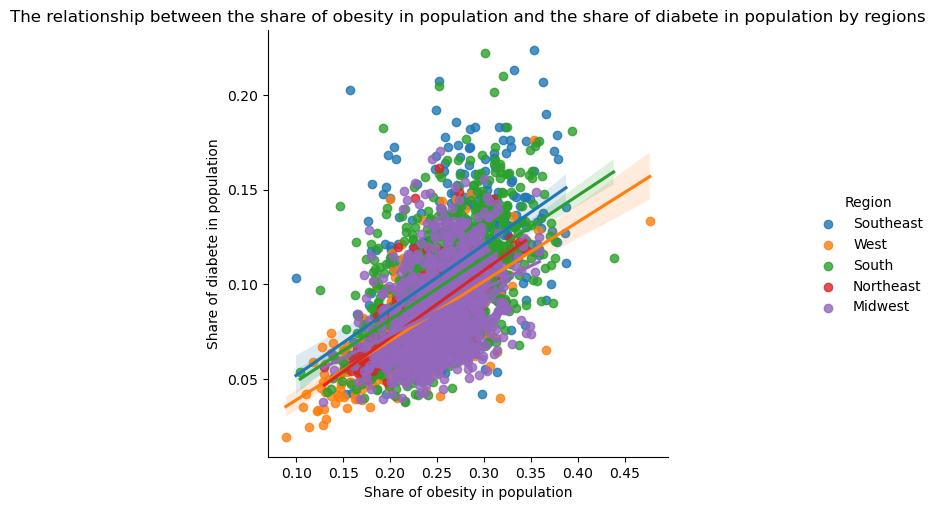

In [229]:
#
# EDA #1 and interpretations in this section 
#-----------

#The interpretation


#code for Scatter Plot with Regression Line
sns.lmplot(data=diabetes, x='Obesity_Number', y='Diabetes_Number', hue='Region')
# Add a chart title using Matplotlib 
plt.title("The relationship between the share of obesity in population and the share of diabete in population by regions")
plt.xlabel("Share of obesity in population")
plt.ylabel("Share of diabete in population")

_EDA #2 interpretation_

_The EDA #2 chart clear shows a positive correlation between the share of physically inactive people in population and the share of diabete people in population accross regions. This positive relationship is supported by sciantific evidence that being physically inactive can lead to high risk of being diabete._ 

Text(47.24104166666666, 0.5, 'Share of diabete in population')

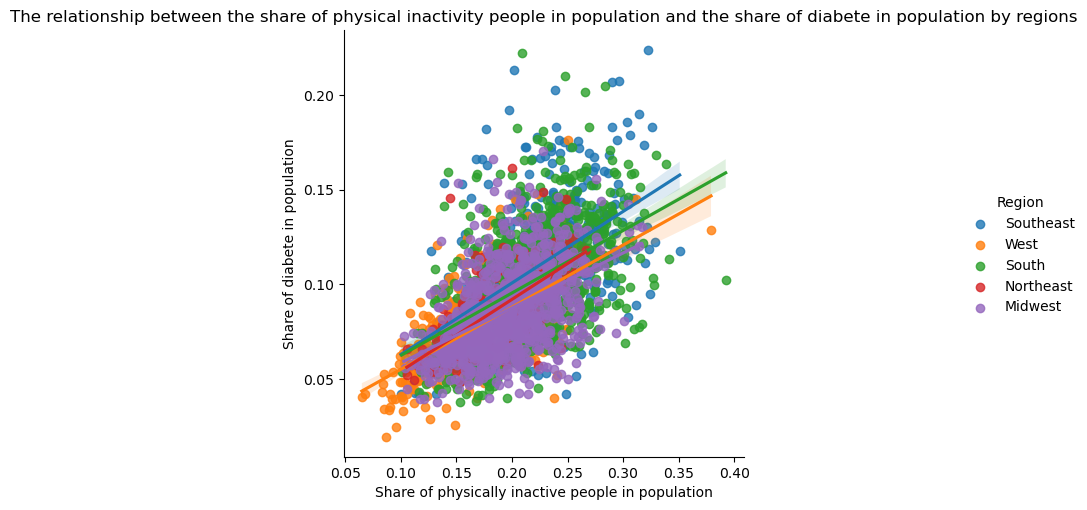

In [230]:
#
# EDA #2 and interpretations in this section 
#-----------

#code for Scatter Plot with Regression Line
sns.lmplot(data=diabetes, x='Physical_Inactivity_Number', y='Diabetes_Number', hue='Region')
# Add a chart title using Matplotlib 
plt.title("The relationship between the share of physical inactivity people in population and the share of diabete in population by regions")
plt.xlabel("Share of physically inactive people in population")
plt.ylabel("Share of diabete in population")

_EDA #3 interpretation_

_The EDA #3 chart shows that the counties in 4th quartile of share of black people in propulation has significant higher share of population with diabete. This evidence is needed to investigate more on other socioeconomic factors or other unfair structural issues that lead to this outcome._ 

Text(0, 0.5, 'Share of diabete in population')

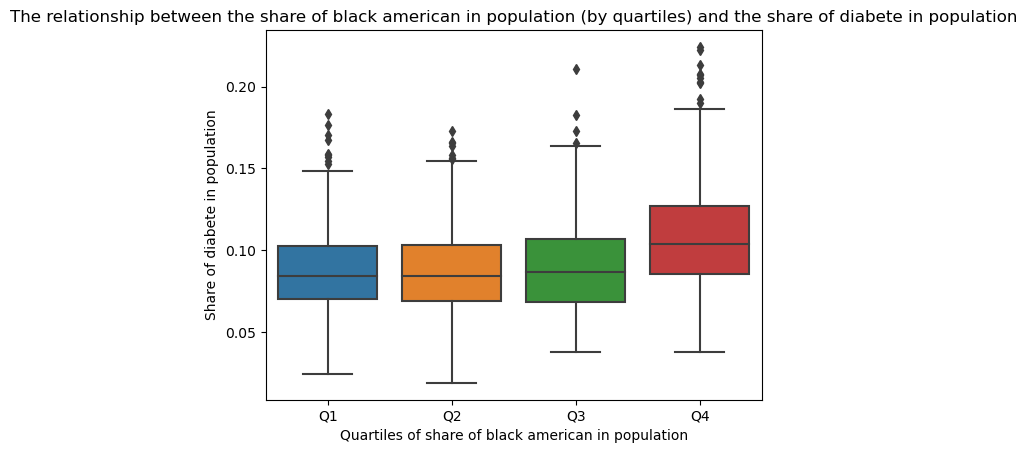

In [231]:
#
# EDA #3 and interpretations in this section 
#-----------

# create quartile variable of share of black people
# Calculate quartiles
quartiles = np.percentile(diabetes['race_total population_one race_black or african american'], [25, 50, 75])

# Assign quartile labels
diabetes['quartile_black'] = pd.cut(diabetes['race_total population_one race_black or african american'],
                                  bins=[0] + list(quartiles) + [float('inf')],
                                  labels=['Q1', 'Q2', 'Q3', 'Q4'])


sns.boxplot(data=diabetes, x='quartile_black', y='Diabetes_Number')
# Add a chart title using Matplotlib 
plt.title("The relationship between the share of black american in population (by quartiles) and the share of diabete in population")
plt.xlabel("Quartiles of share of black american in population")
plt.ylabel("Share of diabete in population")

## 3. Prepare to Fit Models

### 3.1 Finalize Data Set

We've already cleaned up the data, but we can make a few more adjustments before partitioning the data and training models. Let's recode 'Region' to be a categorical variable using `pd.get_dummies` and drop 'State'. Also, we'll drop 'County' because 'CountyFIPS' is already a unique identifier for the county. 

In [232]:
#
# Drop and get dummies
#-----------

# create dummy features out of 'Region', which might be related to diabetes rates 
diabetes_clean = pd.get_dummies(diabetes, 
                               columns = ['Region'],  
                               drop_first = True) # drop the first as a reference 

# drop 'County' and 'State' variables
diabetes_clean = diabetes_clean.drop(labels = ['County', 'State'],
                               axis = 1) # which axis tells python we want to drop columns rather than index rows?

# look at first 10 rows of new data frame 
diabetes_clean.head(10)

,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -

### 3.2 Partition Data, Feature Selection, and Standardization

Now, we will partition our data to prepare it for the training process. Ultimately we want to use a 60% train—20% validation—20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough.

Work through partitioning the data into the test/train/validation sets in the chunks below. Be sure to that if you are using Ridge or LASSO, you Standardize the data. Where you do this in the workflow matters so be clear about where you are doing this and why. 

In [233]:
#
# Partition data
#-----------

# import library
from sklearn.model_selection import train_test_split

# create y dataframe 
y = diabetes_clean['Diabetes_Number']

# create X dataframe (include everything except "Diabetes_Number", our target, 
# and "race alone or in combination with one or more other races_total population")
X = diabetes_clean.drop(labels = ['Diabetes_Number', 'race alone or in combination with one or more other races_total population'],
                               axis = 1)

Investigate whether there are any features that you should remove prior to spliting and model fitting. You may also consider using plots and relationships you found in the EDA stage for this question. Be sure to justify your logic. 

In [234]:
#
# Feature selection
#-----------

#Based on our EDA, it is rational to drop races that have small populations and young age variables# List of columns to exclude
columns_to_exclude = ['race_total population_two or more races_white and black or african american',
       'race_total population_two or more races_white and american indian and alaska native',
       'race_total population_two or more races_white and asian',
       'race_total population_two or more races_black or african american and american indian and alaska native',
       'race alone or in combination with one or more other races_total population_white',
       'race alone or in combination with one or more other races_total population_black or african american',
       'race alone or in combination with one or more other races_total population_american indian and alaska native',
       'race alone or in combination with one or more other races_total population_asian',
       'race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander',
       'race alone or in combination with one or more other races_total population_some othver race', 'sex and age_total population_under 5 years',
       'sex and age_total population_5 to 9 years', 'sex and age_total population_10 to 14 years',
       'citizen -  voting age population_citizen -  18 and over population',
       'citizen -  voting age population_citizen -  18 and over population_male',
       'citizen -  voting age population_citizen -  18 and over population_female',
       'sex and age_total population_male',
       'sex and age_total population_female','decile_black',
       'quartile_black',]
X= X.loc[:, ~X.columns.isin(columns_to_exclude)]

In [235]:
#
# Training/test split
#-----------

# set the random seed
np.random.seed(10)


# split the data so that it returns 4 values: X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X,                 # specify training dataset
                                                    y,                 # specify test dataset
                                                    train_size=0.8,      # specify proportional split for training
                                                    test_size=0.2)       # specify proportional split for test

In [236]:
#
# Validation split
#-----------

# train_test_split returns 4 values: X_train, X_test, y_train, y_test, so how do we create a 60-20-20 train-validate-test split? 
X_train, X_validate, y_train, y_validate =  train_test_split(X_train,         # specify training x
                                                            y_train,         # specify training y
                                                            train_size=0.75, # set training proportional spilt
                                                            test_size=0.25)  # set testing proportional split

In [237]:
#
# Standardization
#-----------
# Given that we want to only standardize non-dichotomous variables, we need to find a 
# solution that will loop over only the columns we want to standardize. The code below
# identifies all non-dichotomous variables in our dataset and only standardizes those.

# load library and create instance of Standard Scaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# identify non-dichotomous columns we want to transform
columns = list(X_test.select_dtypes(include=['number']).loc[:, X_test.nunique() > 2])

# use loop to transform training data for only columns we want to transform
for column in columns:
    X_train[column] = scaler.fit_transform(X_train[column].values.reshape(-1, 1)).flatten()

# use loop to transform validation data for only columns we want to transform
for column in columns:
    X_validate[column] = scaler.fit_transform(X_validate[column].values.reshape(-1, 1)).flatten()

# use loop to transform test data for only columns we want to transform
for column in columns:
    X_test[column] = scaler.fit_transform(X_test[column].values.reshape(-1, 1)).flatten()

## 4. Train Models

In this section, train your models. 

**Note that if you use Lasso, you will likely need to specify a very high penalty (very low, like alpha of 0.001) because of convergence problems.**

### 4.1 Describe models

Detail the basic logic and assumptions underlying each model, its pros/cons, and why it is a plausible choice for this problem.

**MODEL DESCRIPTION(S):** ...

### 4.2 Train models

Train each model in the training set, and be sure to tune hyperparameters if appropriate. Report any relevant summary statistics from the training set, including how well each model fits the training data.

#### Model 1:  (Linear Regression (OLS)) 

In [238]:
#
# Model 1 training
#-----------

#import libraries
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV



# create function to calculate the root mean squared errror
def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))


# create a model
lin_reg = LinearRegression()

# fit the model
lin_model = lin_reg.fit(X_train, y_train)

# specify the hyperparameters
param_grid = {'fit_intercept': [True, False]}          # use dictionary for tuning

# execute the grid search
lin_grid_reg = GridSearchCV(estimator  = lin_reg,      # model to be tuned
                            param_grid = param_grid,   # parameters to be searched as specified above
                            cv=3)                      # 3-fold cross-validation to be used during hypertuning

# now fit the tuning on the training data
lin_grid_reg.fit(X_train, y_train)

# select the best performing model and predict with that on training dataset
best_index = np.argmax(lin_grid_reg.cv_results_["mean_test_score"])  # find the best performing model
best_lin_pred = lin_grid_reg.best_estimator_.predict(X_train)     # find best estimator and predict on training

# print the results  
print(lin_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2:', max(lin_grid_reg.cv_results_["mean_test_score"]))
print('Training R^2:', lin_grid_reg.score(X_train, y_train))
print('Training RMSE', rmse(best_lin_pred, y_train))


{'fit_intercept': True}
Best CV R^2: 0.4729095700421119
Training R^2: 0.534933194904184
Training RMSE 0.019704069937906424


#### Model 2:  (Ridge Regression) 

In [239]:
#
# Model 2 training
#-----------

# make and fit a Ridge regression model
ridge_reg = Ridge()                                              # create the model
ridge_model = ridge_reg.fit(X_train, y_train)                    # fit the model

# specify the hyperparameters
param_grid = {'alpha': np.arange(.1, 1, .1),
              'fit_intercept': [True, False],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr']}

# execute the grid search
ridge_grid_reg = GridSearchCV(ridge_reg,  # model to be tuned
                              param_grid, # parameters to be searched as specified above
                              cv=3)       # 3-fold cross-validation to be used during hypertuning

# fit the tuning on the training data
ridge_grid_reg.fit(X_train, y_train)

# select the best performing model and predict with that on training set 
best_index = np.argmax(ridge_grid_reg.cv_results_["mean_test_score"])  # find the best performing model
best_ridge_pred = ridge_grid_reg.best_estimator_.predict(X_train)   # find best estimator and predict on training

# print the results  
print(ridge_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Training R^2:', ridge_grid_reg.score(X_train, y_train))
print('Training RMSE', rmse(best_ridge_pred, y_train))

{'alpha': 0.9, 'fit_intercept': True, 'solver': 'auto'}
Best CV R^2: 0.47904352774155806
Training R^2: 0.5343860067591828
Training RMSE 0.019715658234257655


#### Model 3:  (LASSO Regression) 

In [240]:
#
# Model 3 training
#-----------

# create and fit the model
lasso_reg = Lasso()  # note the hypterparameter tuning will not converge with max_iter < 15000
lasso_model = lasso_reg.fit(X_train, 
                            y_train)

# specify the hyperparameters
param_grid = {'alpha': np.arange(.1, 5, .1),
              'fit_intercept': [True, False],
              'selection': ['cyclic', 'random']}

# execute the grid search
lasso_grid_reg = GridSearchCV(lasso_reg,  # model to be tuned
                              param_grid, # parameters to be searched as specified above
                              cv=3)       # 3-fold cross-validation to be used during hypertuning

# now fit the tuning on the training data
lasso_grid_reg.fit(X_train, y_train)

# select the best performing model and predict with that on training dataset 
best_index = np.argmax(lasso_grid_reg.cv_results_["mean_test_score"])   # find the best performing model
best_lasso_pred = lasso_grid_reg.best_estimator_.predict(X_train)    # find best estimator and predict on training

# print results
print(lasso_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2:', max(lasso_grid_reg.cv_results_["mean_test_score"]))
print('Training R^2:', lasso_grid_reg.score(X_train, y_train))
print('Training RMSE', rmse(best_lasso_pred, y_train))

{'alpha': 0.1, 'fit_intercept': True, 'selection': 'cyclic'}
Best CV R^2: -0.0012865425853822627
Training R^2: 0.00126108278636905
Training RMSE 0.028875150453787087


## 5. Validate and Refine Models

### 5.1 Predict on the validation set
Using each of the models you trained, predict outcomes in the validation set. Evaluate how well each model did.

In [241]:
#
# Predict on validation data
#-----------


# Linear model using the validation dataset and the trained model, predict 
best_lin_pred = lin_grid_reg.best_estimator_.predict(X_validate)     # find best estimator and predict on validate

# print the results  
print(lin_grid_reg.cv_results_["params"][best_index])
print('Linear Best CV R^2:', max(lin_grid_reg.cv_results_["mean_test_score"]))
print('Linear Validation R^2:', lin_grid_reg.score(X_validate, y_validate))
print('Linear Validation RMSE', rmse(best_lin_pred, y_validate))


# Ridge model using the validation dataset and the trained model, predict
best_ridge_pred = ridge_grid_reg.best_estimator_.predict(X_validate)   # find best estimator and predict on validate

# print the results  
print(ridge_grid_reg.cv_results_["params"][best_index])
print('Ridge Best CV R^2:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Ridge Validation R^2:', ridge_grid_reg.score(X_validate, y_validate))
print('Ridge Validation RMSE', rmse(best_ridge_pred, y_validate))

# Lasso model using the validation dataset and the trained model, predict
best_lasso_pred = lasso_grid_reg.best_estimator_.predict(X_validate)    # find best estimator and predict on validate

# print results
print(lasso_grid_reg.cv_results_["params"][best_index])
print('Lasso Best CV R^2:', max(lasso_grid_reg.cv_results_["mean_test_score"]))
print('Lasso Validation R^2:', lasso_grid_reg.score(X_validate, y_validate))
print('Lasso Validation RMSE', rmse(best_lasso_pred, y_validate))

{'fit_intercept': True}
Linear Best CV R^2: 0.4729095700421119
Linear Validation R^2: 0.4119183466604467
Linear Validation RMSE 0.01995823454411013
{'alpha': 0.1, 'fit_intercept': True, 'solver': 'auto'}
Ridge Best CV R^2: 0.47904352774155806
Ridge Validation R^2: 0.45002649641652026
Ridge Validation RMSE 0.019300750205728127
{'alpha': 0.1, 'fit_intercept': True, 'selection': 'cyclic'}
Lasso Best CV R^2: -0.0012865425853822627
Lasso Validation R^2: 0.001292167120310883
Lasso Validation RMSE 0.026008932928432527


### 5.2 Predict on the test set

Now, choose your best performing model of the three, select out unimportant feature(s), retrain the model, and then predict on the test set. 

{'alpha': 0.1, 'fit_intercept': True, 'solver': 'auto'}
Ridge Best CV R^2: 0.47904352774155806
Ridge Validation R^2: 0.4348423978708865
Ridge Validation RMSE 0.03423284500014626


,Coefficient,Feature
1,0.008192,Obesity_Number
2,0.007426,Physical_Inactivity_Number
8,0.007815,race_total population_one race_black or africa...
28,0.016904,race alone or in combination with one or more ...
67,0.011587,sex and age_total population_65 years and over...
69,0.007353,Region_South
70,0.007664,Region_Southeast


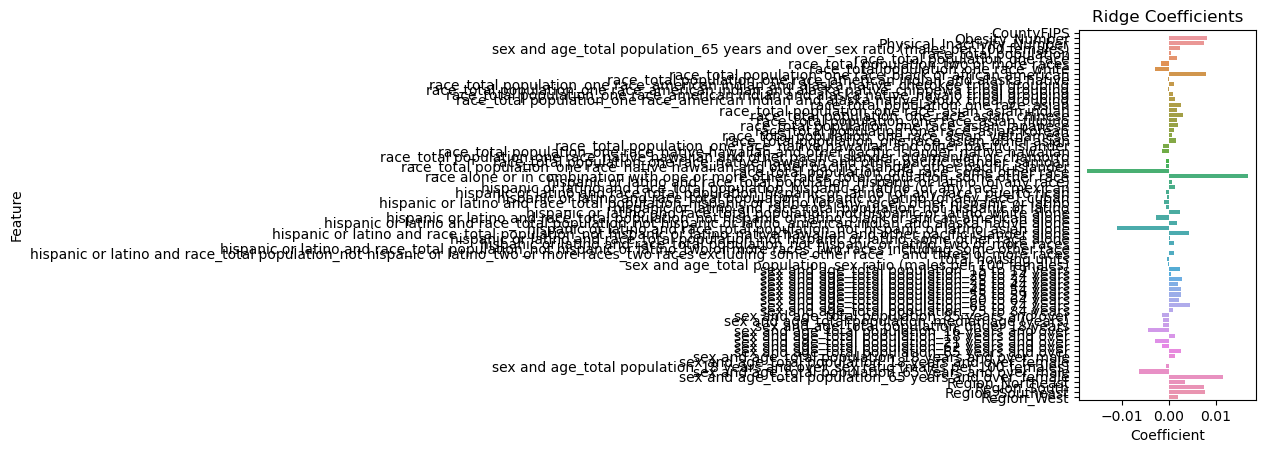

In [242]:
#
# Predict using your best model
#-----------

#Ridge model is the best perform. using it to predict in test set
best_pred = ridge_grid_reg.best_estimator_.predict(X_test)

# print the results  
print(ridge_grid_reg.cv_results_["params"][best_index])
print('Ridge Best CV R^2:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Ridge Validation R^2:', ridge_grid_reg.score(X_test, y_test))
print('Ridge Validation RMSE', rmse(best_ridge_pred, y_test))

# set the figure 
figure = plt.figure()                            # set the figure space
figure.subplots_adjust(wspace = .8, hspace=.5)   # adjust the space in between figures 

# plot 1
# ----------
figure.add_subplot(1,   # sets the number of rows
                   2,   # sets columns,
                   1)   # specifies the following code is for the first plot  

# specify barplot for Ridge 
sns.barplot(x="Coefficient", 
            y="Feature", 
            data=ridge_reg_data).set_title("Ridge Coefficients")

ridge_reg_data[ridge_reg_data['Coefficient']>.005]


### 5.3 Impement a cross-validation approach

Finally, implement a cross-validation approach for your best model and evaluate the results.

In [243]:
#
# Run cross-validation
#-----------

# load libraries
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# specify cross validation
cv_ridge_pred = cross_val_predict(estimator = ridge_grid_reg,       # specifcy object that is implementing fit 
                             X = X,                     # features
                             y = y,                     # target variable 
                             cv = 3)                    # how many folds

# print the results  
print(ridge_grid_reg.cv_results_["params"][best_index])
print('Ridge Best CV R^2:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Ridge Validation R^2:', ridge_grid_reg.score(X_test, y_test))
print('Ridge Validation RMSE', rmse(best_ridge_pred, y_test))

{'alpha': 0.1, 'fit_intercept': True, 'solver': 'auto'}
Ridge Best CV R^2: 0.47904352774155806
Ridge Validation R^2: 0.4348423978708865
Ridge Validation RMSE 0.03423284500014626


## 6. Discussion Questions

In this section, insert responses for discussion questions here.

1. What is bias-variance tradeoff? Why is it relevant to machine learning problems like this one?

**The bias-variance tradeoff arises when we try to reduce bias by increasing a model's complexity, but, unintentionally, the variance of the modle's prediction increase at the same time. It is relavant because the goal in machine learning is to find the right balance between bias and variance, specific to the problem and dataset. Understanding and managing the bias-variance tradeoff is crucial in machine learning to develop models that generalize well to new data, ensuring robust and reliable predictions in real-world applications.**

2. Define overfitting, and why it matters for machine learning. How can we address it?

**Overfitting occurs when a model learns the training data too well, capturing not only the underlying patterns but also the noise or random fluctuations present in the data. As a result, an overfit model performs well on the training data but poorly on unssen data. Overfitting matters because It reduces generalization: the primary goal of a machine learning model is to make accurate predictions on new, unseen data. Overfit models fail in this regard. To address overfitting, you can use the following techniques: 
1) Regularization: apply regularization techniques such as L1 (Lasso) or L2 (Ridge) regularization to penalize large coefficients and constrain the model's complexity.
2) Cross-Validation: Use cross-validation techniques to estimate a model's performance on unseen data. Cross-validation helps identify overfitting and guides model selection and hyperparameter tuning.**

3. Discuss your analysis in 2-3 paragraphs. Discuss your findings and recommendations. Which counties or regions would you prioritize for the pilot program? Would your answers change based on whether you want to take into account certain features such as race, gender, or age composition in the county? How confident would you be deploying this sort of model in a real-world application – why or why not?

**Based on the result, I will prioritze South and Southeast regions. And share of Black people and people with age more than 65 year-old are significant variable that can change the priority of the county because their coefficients are bigger than regions. I am quit confident with the model because it build on real data from the CDC.**